In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.font_manager as fm
import koreanize_matplotlib

# 폰트 경로 확인 및 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 폰트 경로
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글 깨짐 방지 - 마이너스 기호 처리
plt.rcParams['axes.unicode_minus'] = False

In [15]:

# 서비스 계정 키 경로 설정
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"/home/eunyu/sprintda05-eunyu-a9946f7dea9c.json"

# GCS의 Parquet 파일 경로
gcs_path = 'gs://final_project_enuyu/data/final_project/votes/accounts_blockrecord.parquet'

# 데이터 불러오기
blockrecord_df = pd.read_parquet(gcs_path, engine='pyarrow')
blockrecord_df

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177
...,...,...,...,...,...
19477,25355,사칭 계정,2024-04-05 08:15:03,875351,879416
19478,25356,친구 사이가 어색해짐,2024-04-25 09:28:19,1444256,1292346
19479,25357,친구 사이가 어색해짐,2024-04-25 09:28:24,1379126,1292346
19480,25360,모르는 사람임,2024-05-05 11:06:31,1582869,1583612


In [16]:
blockrecord_df['reason'].value_counts()

reason
모르는 사람임               9640
친구 사이가 어색해짐           5805
사칭 계정                 2022
나랑 관련 없는 질문을 자꾸 보냄    1083
너무 많은 양의 질문을 보냄        919
기타                       7
그냥...                    6
Name: count, dtype: int64

In [17]:
missing_values = blockrecord_df.isnull().sum()

missing_values

id               0
reason           0
created_at       0
block_user_id    0
user_id          0
dtype: int64

In [18]:
blockrecord_df.dtypes

id                        int64
reason                   object
created_at       datetime64[ns]
block_user_id             int64
user_id                   int64
dtype: object

In [19]:
blockrecord_df.describe(include='all')

,id,reason,created_at,block_user_id,user_id
count,19482.000000,19482,19482,1.948200e+04,1.948200e+04
unique,NaN,7,NaN,NaN,NaN
top,NaN,모르는 사람임,NaN,NaN,NaN
freq,NaN,9640,NaN,NaN,NaN
mean,12694.563495,NaN,2023-05-25 19:12:26.516579584,1.183576e+06,1.175780e+06
min,1.000000,NaN,2023-05-04 23:01:53,8.327400e+05,8.376150e+05
25%,6514.250000,NaN,2023-05-14 02:19:01,1.001336e+06,9.890410e+05
50%,12731.000000,NaN,2023-05-22 11:37:20,1.173390e+06,1.160726e+06
75%,18984.750000,NaN,2023-05-28 11:04:33,1.357468e+06,1.345758e+06
max,25361.000000,NaN,2024-05-06 13:03:37,1.582869e+06,1.583612e+06



[reason] 고유값 수: 7
reason
모르는 사람임               9640
친구 사이가 어색해짐           5805
사칭 계정                 2022
나랑 관련 없는 질문을 자꾸 보냄    1083
너무 많은 양의 질문을 보냄        919
Name: count, dtype: int64


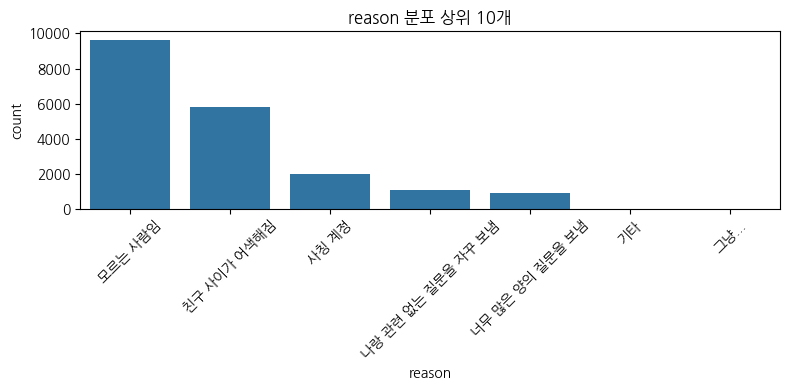

In [20]:
categorical_cols = blockrecord_df.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    print(f"\n[{col}] 고유값 수:", blockrecord_df[col].nunique())
    print(blockrecord_df[col].value_counts().head())

    # 시각화
    plt.figure(figsize=(8, 4))
    sns.countplot(data=blockrecord_df, x=col, order=blockrecord_df[col].value_counts().index[:10])
    plt.title(f'{col} 분포 상위 10개')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

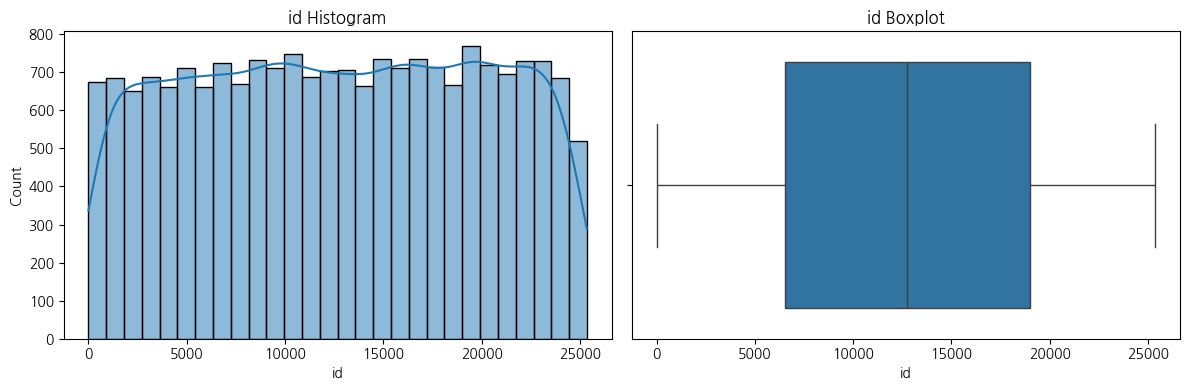

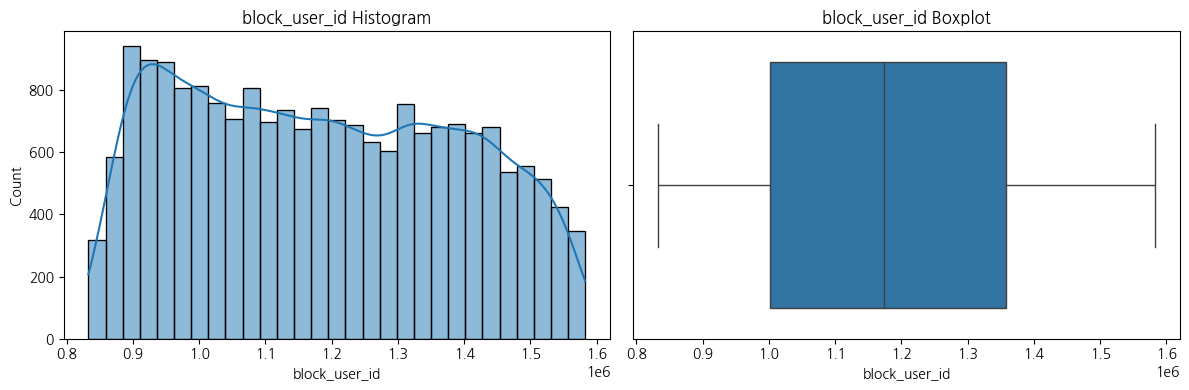

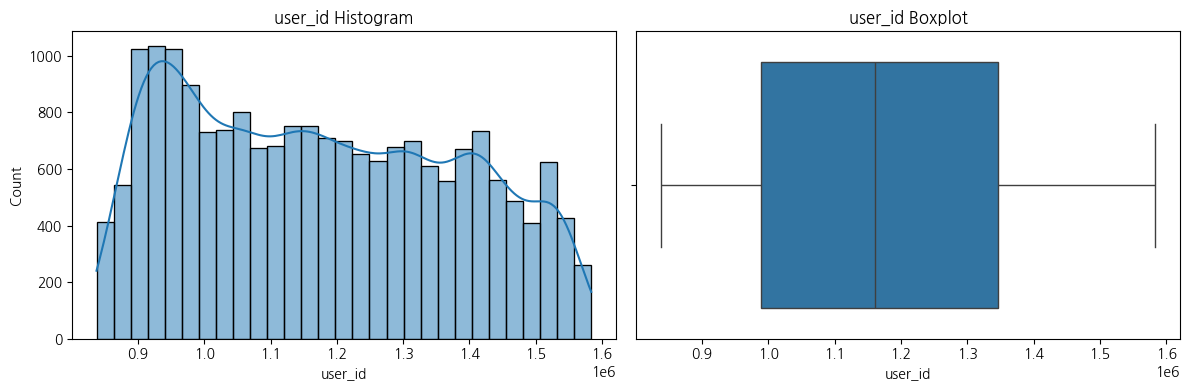

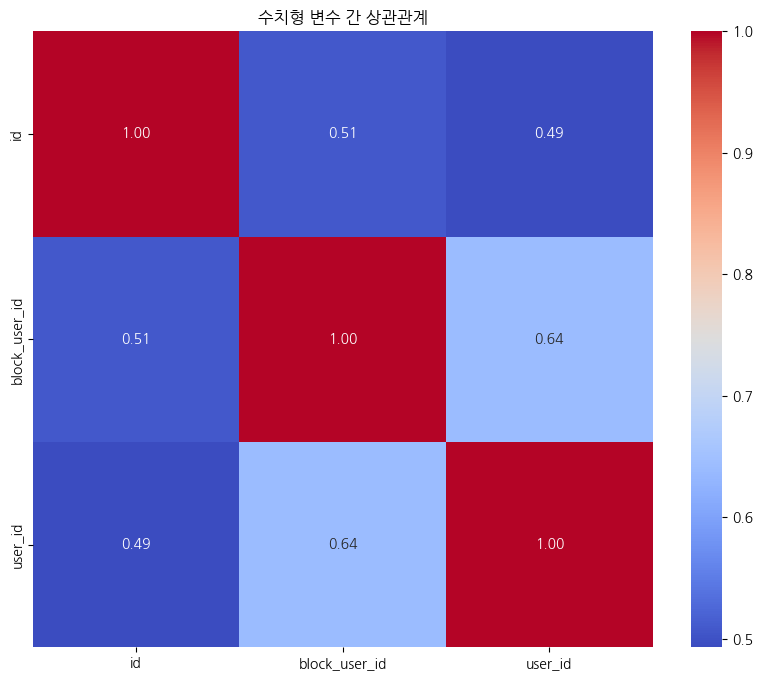

In [21]:
numeric_cols = blockrecord_df.select_dtypes(include=['int64', 'float64']).columns

# 분포 확인
for col in numeric_cols:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(blockrecord_df[col], kde=True)
    plt.title(f'{col} Histogram')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=blockrecord_df[col])
    plt.title(f'{col} Boxplot')

    plt.tight_layout()
    plt.show()

# 상관관계 히트맵
plt.figure(figsize=(10, 8))
sns.heatmap(blockrecord_df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("수치형 변수 간 상관관계")
plt.show()


#### 차단 많이 당한 유저 추출

In [22]:
# block_user_id 기준으로 몇 번 차단당했는지 집계
blocked_counts = blockrecord_df['block_user_id'].value_counts()

# 상위 10명 보기
blocked_counts.head(10)

block_user_id
898020     76
877266     25
897681     25
1380465    25
1395312    24
876207     24
1198628    21
1495281    19
1031842    18
1186363    17
Name: count, dtype: int64

#### 누가 자주 차단을 했는지 (차단을 자주 하는 유저)

In [23]:
blockrecord_df['user_id'].value_counts().head()

user_id
1526194    171
1415197    163
1519819     70
1542675     66
986459      60
Name: count, dtype: int64